# MODELLING AND FORECASTING STORE SALES OF A TIME-SERIES DATA.

## Description

This is a time-series forecasting project.In this project we'll train a model that accurately predicts the sales of items in different stores.We'll use store sales data from large Ecuadorian-based grocery retailer.

## Hypothesis

Null hypothesis: Stores with products onpromotion make more sales than stores without onpromotion products.

Alternative hypothesis: Stores with no promotion products make more sales than stores with onpromotion products.

## Questions

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year?
3. Did the earthquake impact sales?
4. Are certain groups of stores selling more products? (Cluster, city, state, type)
5. Are sales affected by promotions, oil prices and holidays?
6. What analysis can we get from the date and its extractable features?
7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
8. What are the annual sales that each store make.
9. How many sales are made on the 1st quarter of each year 
10. What is the trend of the sales over the years?

## Importations

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Data Visualizations
from matplotlib import pyplot as plt

# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

#import sklearn libraries
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pickle
import subprocess  #function is used to call the 7-Zip command-line interface with the appropriate arguments.
# EDA
#from pandas_profiling import ProfileReport
from pandas.plotting import scatter_matrix
from itertools import product
# handle memory error
import os
import gc

import warnings
warnings.filterwarnings('ignore')


#### handle huge memory problem

In [2]:
# use garbage collector to release unreferenced memory()  
gc.collect()

0

# Data Loading

### Here is the section to load the datasets (train, eval, test) and the additional files

In [3]:
#importing the datasets
train_df  =pd.read_csv(r"C:\Users\Nathaniel Havim\Desktop\Azubi_Projects\LP2_DAP\train.csv",parse_dates=['date'])
events_df =pd.read_csv(r"C:\Users\Nathaniel Havim\Desktop\Azubi_Projects\LP2_DAP\holidays_events.csv",parse_dates=['date'])
oil_df    =pd.read_csv(r"C:\Users\Nathaniel Havim\Desktop\Azubi_Projects\LP2_DAP\oil.csv",parse_dates=['date'])
store_df  =pd.read_csv(r"C:\Users\Nathaniel Havim\Desktop\Azubi_Projects\LP2_DAP\stores.csv")
test_df   =pd.read_csv(r"C:\Users\Nathaniel Havim\Desktop\Azubi_Projects\LP2_DAP\test.csv",parse_dates=['date'])

## Training Data

In [4]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [6]:
train_df.shape

(3000888, 6)

In [7]:
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

## Events Data

In [8]:
events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [10]:
events_df.shape

(350, 6)

In [11]:
events_df.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

## Oil Data

In [12]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [13]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [14]:
oil_df['date'].agg(['min', 'max'])

min   2013-01-01
max   2017-08-31
Name: date, dtype: datetime64[ns]

In [15]:
#Getting the missing dates 
oil_missing_dates=pd.date_range(start='2013-01-01', end='2017-08-31').difference(oil_df.date.unique())

In [16]:
oil_missing_dates

DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13', '2017-08-19', '2017-08-20',
               '2017-08-26', '2017-08-27'],
              dtype='datetime64[ns]', length=486, freq=None)

In [17]:
missing_data = pd.DataFrame(oil_missing_dates, columns=['date'])

In [18]:
#combining the original train data with the missing date dataframe
oil_data=pd.concat([oil_df,missing_data],ignore_index= True)
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [19]:
oil_data['dcoilwtico'].interpolate(method ='linear', limit_direction ='both',inplace=True)

In [20]:
oil_data.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [21]:
oil_data.shape

(1704, 2)

## Store Data

In [22]:
store_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [23]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [24]:
store_df.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [25]:
store_df.shape

(54, 5)

## Test data

In [26]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [28]:
test_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [29]:
test_df.shape

(28512, 5)

## Exploratory Data Analysis: EDA

## 1. Is the train dataset complete (has all the required dates)?


In [30]:
train_df['date'].agg(['min', 'max'])

min   2013-01-01
max   2017-08-15
Name: date, dtype: datetime64[ns]

In [31]:
#Getting the missing dates 
train_missing_dates=pd.date_range(start='2013-01-01', end='2017-08-15').difference(train_df.date.unique())

In [32]:
train_missing_dates

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

### filling the missing dates

In [33]:
added_dates=list(product(train_missing_dates,train_df.store_nbr.unique(),train_df.family.unique()))

In [34]:
train_missing_data = pd.DataFrame(added_dates, columns=['date','store_nbr','family'])

In [35]:
train_missing_data.head()

,date,store_nbr,family
0,2013-12-25,1,AUTOMOTIVE
1,2013-12-25,1,BABY CARE
2,2013-12-25,1,BEAUTY
3,2013-12-25,1,BEVERAGES
4,2013-12-25,1,BOOKS


In [36]:
#combining the original train data with the missing date dataframe
train_data=pd.concat([train_df,train_missing_data],ignore_index= True)
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0
4,4.0,2013-01-01,1,BOOKS,0.0,0.0


In [37]:
train_data.duplicated().sum()

0

In [38]:
train_data.isna().sum()

id             7128
date              0
store_nbr         0
family            0
sales          7128
onpromotion    7128
dtype: int64

In [39]:
train_data.shape

(3008016, 6)

## merging the different csv files into one dataframe

In [40]:
#combining train data with storedata
train_store_df=pd.merge(train_data,store_df,on='store_nbr',how='left')
train_store_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13


In [41]:
#Combining train_store_df with the events_df on the dates
combined_df=pd.merge(train_store_df, events_df, on='date',how='left')
combined_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


In [42]:
df=pd.merge(combined_df,oil_data,on='date',how='left')

In [43]:
df.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred,dcoilwtico
3061471,NaN,2016-12-25,9,POULTRY,NaN,NaN,Quito,Pichincha,B,6,Holiday,National,Ecuador,Navidad,False,47.26
3061472,NaN,2016-12-25,9,PREPARED FOODS,NaN,NaN,Quito,Pichincha,B,6,Holiday,National,Ecuador,Navidad,False,47.26
3061473,NaN,2016-12-25,9,PRODUCE,NaN,NaN,Quito,Pichincha,B,6,Holiday,National,Ecuador,Navidad,False,47.26
3061474,NaN,2016-12-25,9,SCHOOL AND OFFICE SUPPLIES,NaN,NaN,Quito,Pichincha,B,6,Holiday,National,Ecuador,Navidad,False,47.26
3061475,NaN,2016-12-25,9,SEAFOOD,NaN,NaN,Quito,Pichincha,B,6,Holiday,National,Ecuador,Navidad,False,47.26


In [44]:
df.isnull().sum()

id                7128
date                 0
store_nbr            0
family               0
sales             7128
onpromotion       7128
city                 0
state                0
type_x               0
cluster              0
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dcoilwtico           0
dtype: int64

In [45]:
df.shape

(3061476, 16)

In [46]:
#Changing Index to Date Column
df = df.set_index(["date"])

## 2. Which dates have the lowest and highest sales for each year?

In [47]:
#Extracting the dates with lowest sales
lowest_sales = df.groupby(df.index.year)['sales'].idxmin()
lowest_sales

date
2013   2013-01-01
2014   2014-01-01
2015   2015-01-01
2016   2016-01-01
2017   2017-01-01
Name: sales, dtype: datetime64[ns]

In [48]:
#Extracting dates with the highest sales in each year
highest_sales = df.groupby(df.index.year)['sales'].idxmax()
highest_sales

date
2013   2013-11-12
2014   2014-12-08
2015   2015-12-14
2016   2016-05-02
2017   2017-04-02
Name: sales, dtype: datetime64[ns]

The beginning of each year recorded the lowest sales of that year this can be attributed to the feastive season and many people are still home. As for the highest sales that was varied across the different years.

## 3. Did the earthquake impact sales?

In [49]:
# Define the date of the earthquake happend
earthquake_date = pd.to_datetime("2016-04-16")

In [50]:
# Get the sales two weeks before the earthquake
before_sales = df.loc[earthquake_date - pd.Timedelta(weeks=2):earthquake_date, 'sales']
print("Sales two weeks before {}: {}".format(earthquake_date, before_sales))

Sales two weeks before 2016-04-16 00:00:00: date
2016-04-02       6.000
2016-04-02       0.000
2016-04-02       3.000
2016-04-02    2317.000
2016-04-02       0.000
                ...   
2016-04-16     668.427
2016-04-16     135.720
2016-04-16    1496.493
2016-04-16       2.000
2016-04-16      27.638
Name: sales, Length: 26730, dtype: float64


In [51]:
# Get the sales two weeks after the earthquake
after_sales = df.loc[earthquake_date :earthquake_date + pd.Timedelta(weeks=2),'sales']
print("Sales two weeks after {}: {}".format(earthquake_date, after_sales))

Sales two weeks after 2016-04-16 00:00:00: date
2016-04-16       6.00000
2016-04-16       0.00000
2016-04-16       4.00000
2016-04-16    2073.00000
2016-04-16       0.00000
                 ...    
2016-04-30     826.35300
2016-04-30     165.65399
2016-04-30    2012.72700
2016-04-30      10.00000
2016-04-30      32.18600
Name: sales, Length: 28512, dtype: float64


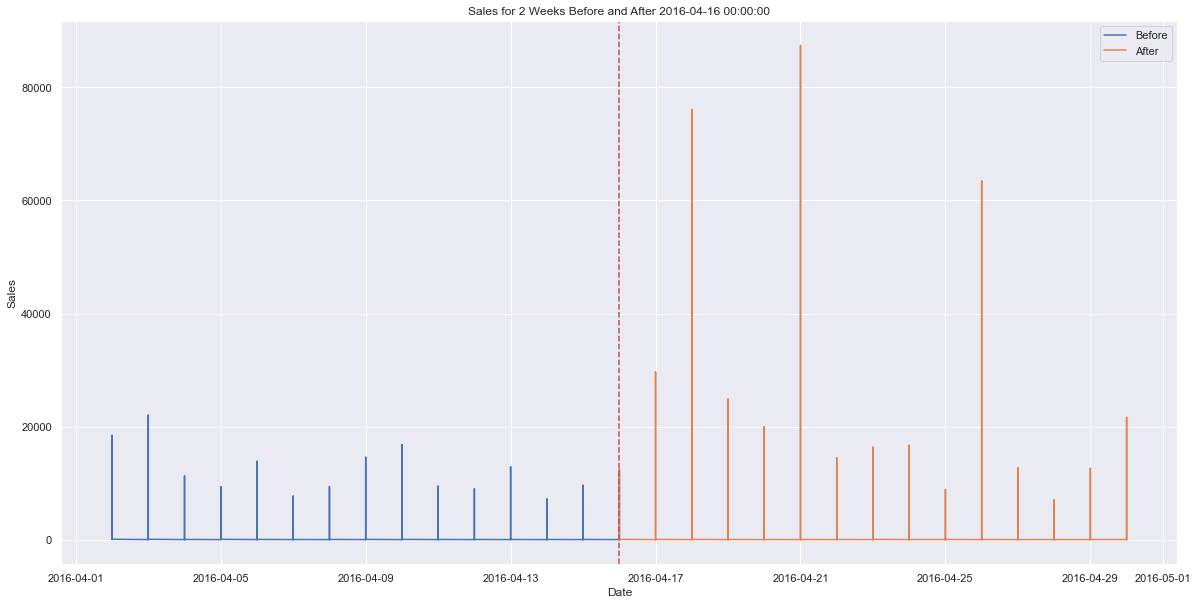

In [52]:
#Extracting the dates 2 weeks before the earthquake
before_df = df.loc[earthquake_date - pd.Timedelta(weeks=2):earthquake_date]

#Extracting the dates 2 weeks after the earthquake
after_df = df.loc[earthquake_date:earthquake_date + pd.Timedelta(weeks=2)]

# Plot the sales before and after the earthquake
plt.figure(figsize=(20, 10))
Before=plt.plot(before_df.index, before_df['sales'], label='Before')
After=plt.plot(after_df.index, after_df['sales'], label='After')

plt.axvline(earthquake_date, color='r', linestyle='--')

plt.title("Sales for 2 Weeks Before and After {}".format(earthquake_date))
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

We did a comparison of sales before the earthquake 2 weeks before and after, we can conclude after the earthquake the sales increased significantly

### 4. Are certain groups of stores selling more products? (Cluster, city, state, type)

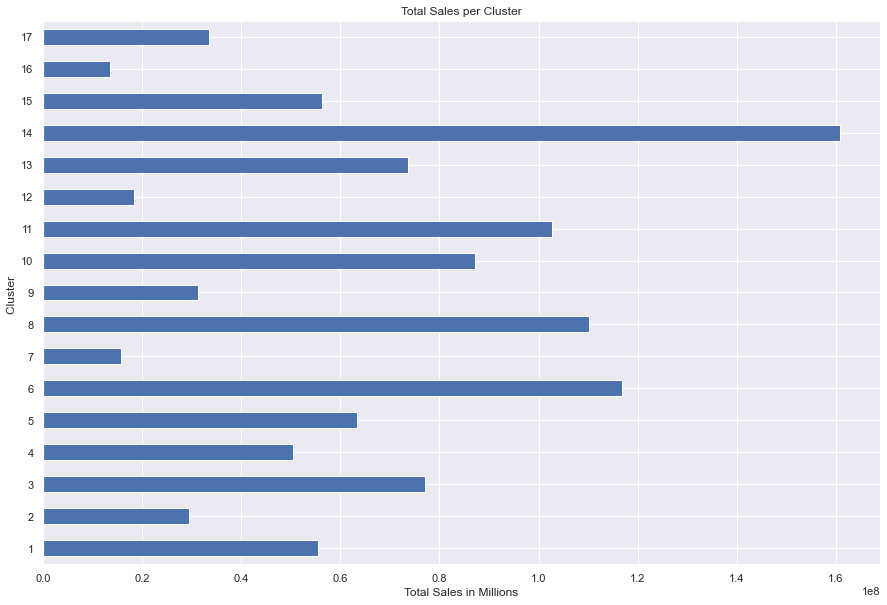

In [53]:
# Group the data by cluster
cluster_groups = df.groupby(['cluster'])['sales'].sum()
plt.figure(figsize=(15, 10))
cluster_groups.plot(kind = 'barh')

# Add a title and axis labels
plt.title("Total Sales per Cluster")
plt.xlabel("Total Sales in Millions")
plt.ylabel("Cluster ")
plt.show()

From the chart we see that cluster 14,6 and 8 are the top 3 with most sales of mote than 1.0 million.

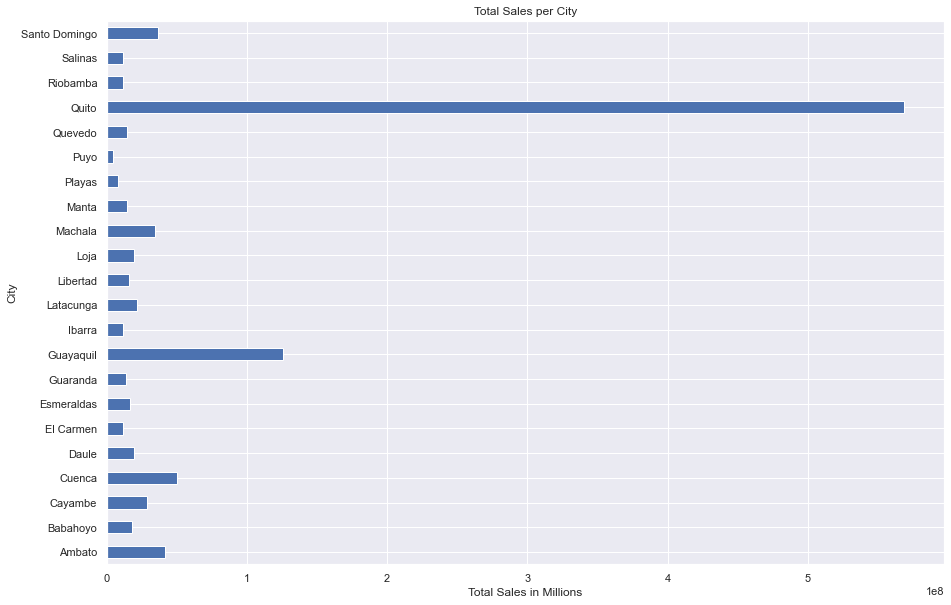

In [54]:
# Group the data by cluster
city_groups = df.groupby(['city'])['sales'].sum()
plt.figure(figsize=(15, 10))
city_groups.plot(kind = 'barh')

# Add a title and axis labels
plt.title("Total Sales per City")
plt.xlabel("Total Sales in Millions")
plt.ylabel("City")

plt.show()

From the chart we see that Quito city has the most sales compared to the rest and this is because many stores are located in  Quito. 

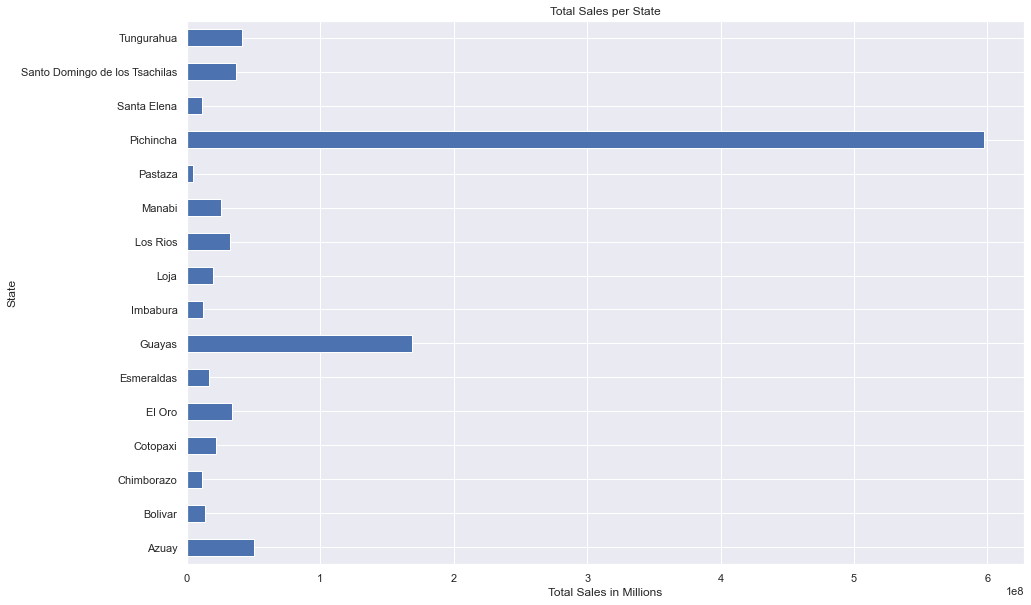

In [55]:
# Group the data by cluster
state_groups = df.groupby(['state'])['sales'].sum()
plt.figure(figsize=(15, 10))
state_groups.plot(kind = 'barh')

# Add a title and axis labels
plt.title("Total Sales per State")
plt.xlabel("Total Sales in Millions")
plt.ylabel("State")

plt.show()

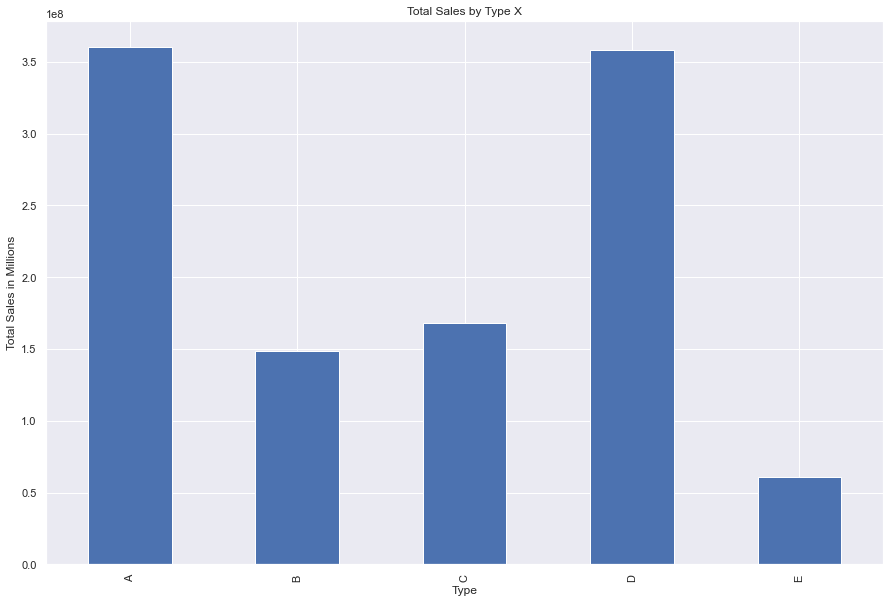

In [56]:
# Group the data by cluster
type_groups = df.groupby(['type_x'])['sales'].sum()
plt.figure(figsize=(15, 10))
type_groups.plot(kind = 'bar')

# Add a title and axis labels
plt.title("Total Sales by Type X")
plt.xlabel("Type")
plt.ylabel("Total Sales in Millions")

plt.show()

### 5. Are sales affected by promotions, oil prices and holidays?

In [57]:
#computing the Pearson correlation coefficient using corr()
corr_matrix= df.corr()

In [58]:
#the Pearson correlation coefficient is to measure the strength of the relationship btwn variables with numeric values
corr_matrix['sales'].sort_values(ascending=False)

sales          1.000000
onpromotion    0.428241
id             0.086102
store_nbr      0.041273
cluster        0.038537
dcoilwtico    -0.074779
Name: sales, dtype: float64

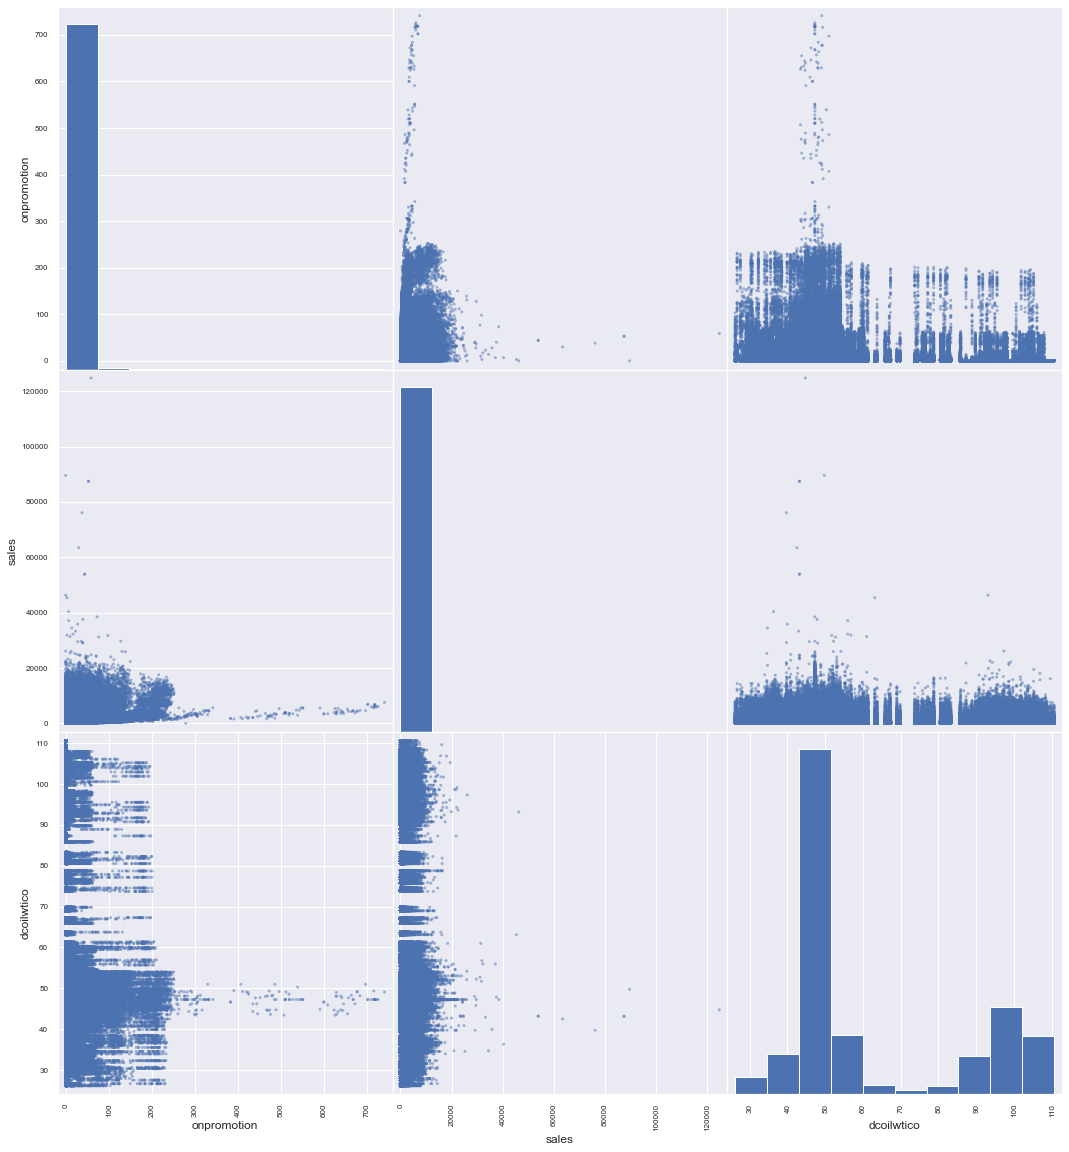

In [59]:
#another method to check the correlation is the pandas scatter_matrix function which plots 
#every numerical attribute against every other numerical attribute.
attributes=['onpromotion','sales','dcoilwtico']
scatter_matrix(df[attributes],figsize=(18,20))
plt.show()

### 6. What analysis can we get from the date and its extractable features?

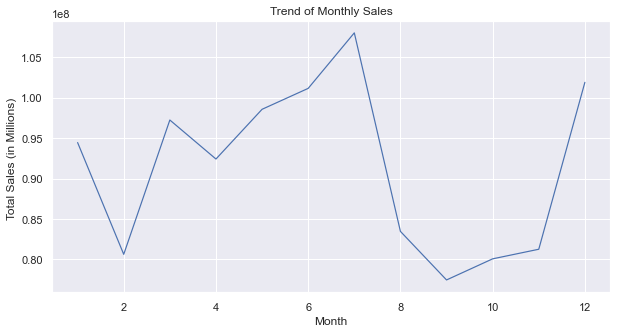

In [60]:
#Using the month extracted fromthe date to get monthly trend of sales
monthly_sales = df.groupby(df.index.month)['sales'].sum()
monthly_sales.plot(linewidth=1.2, figsize=(10,5))

# Add a title and axis labels
plt.title("Trend of Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Total Sales (in Millions) ")

plt.show()

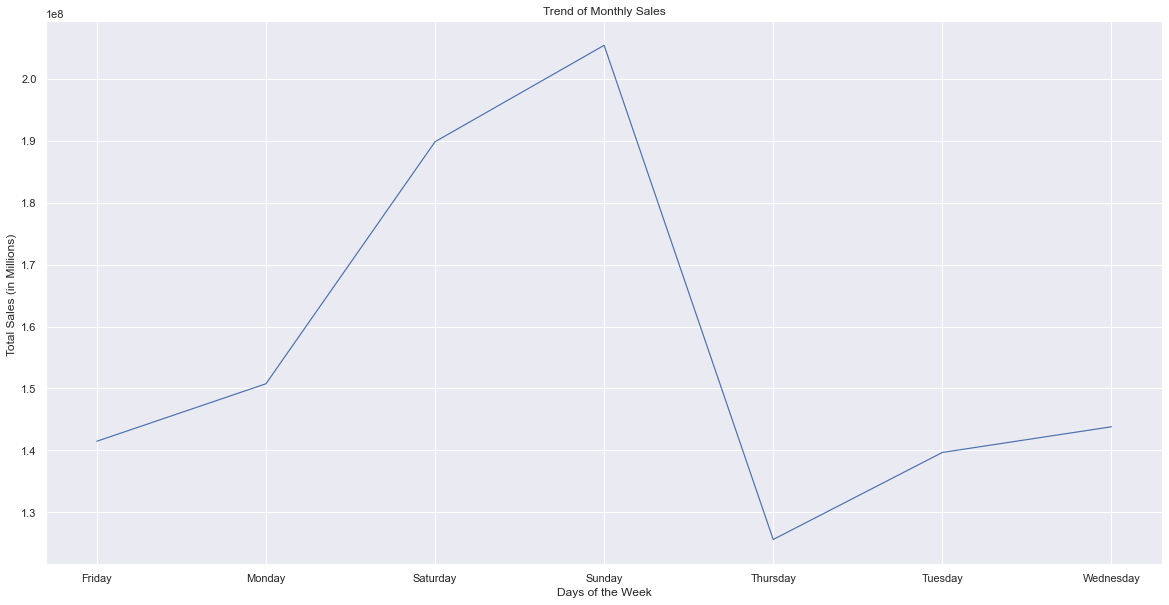

In [61]:
# Using the days of the week extracted from date get the trend of sales of the days of the week
day_sales = df.groupby(df.index.day_name())['sales'].sum()
day_sales.plot(linewidth=1.2, figsize=(20,10))

# Add a title and axis labels
plt.title("Trend of Monthly Sales")
plt.xlabel("Days of the Week")
plt.ylabel("Total Sales (in Millions) ")

plt.show()

### 7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)


MAE (Mean Absolute Error) is the sum of absolute differences between actual and predicted values. It doesn't consider the direction, that is positive or negative.

MSE (Mean Squared Error) is always positive and a value closer to 0 or lower value is better.

RMSE (Root Mean Square Error) is obtained by taking the square root of the mean squared error.

Root Mean Square Log Error (RMSLE) is the root mean square error calculated on the logarithmic scale

### 8.What are the annual sales that each store make

In [62]:
# Group the data by store and year
annual_sales = df.groupby(['store_nbr',df.index.year])['sales'].agg('sum')

In [63]:
# Reset the index to make the store and year columns columns
annual_sales = annual_sales.reset_index()

In [64]:
# Pivot the table so that each row represents a store and columns are the year
annual_sales = annual_sales.pivot(index='store_nbr', columns='date', values='sales')

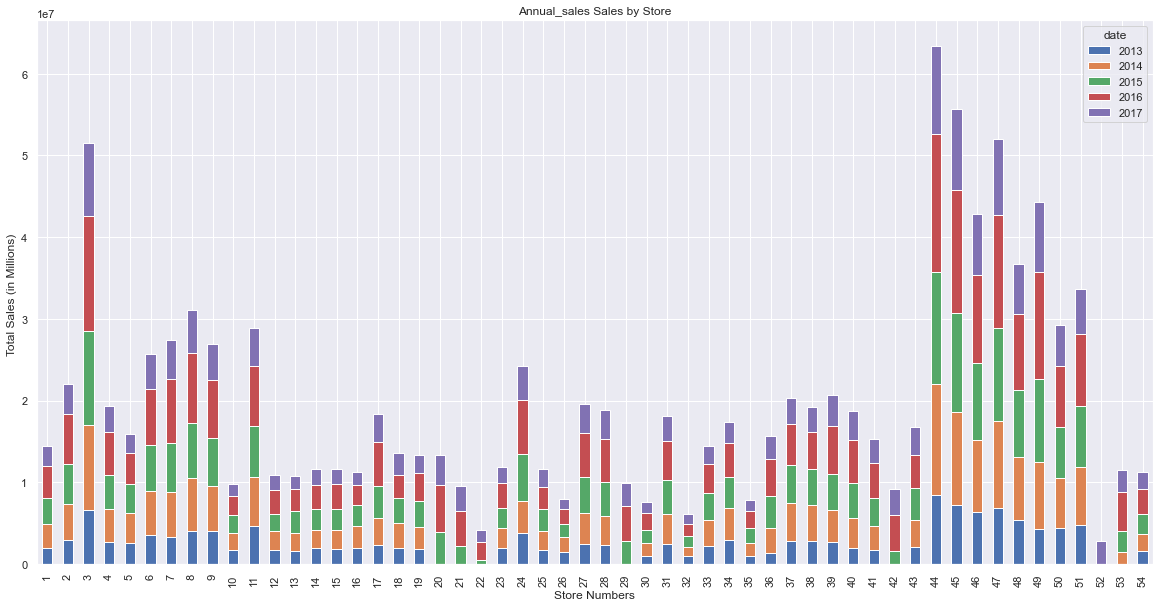

In [65]:
# Plot the yearly sales for each store
annual_sales.plot(kind='bar', stacked=True, figsize=(20,10))

# Add a title and axis labels
plt.title("Annual_sales Sales by Store")
plt.xlabel("Store Numbers")
plt.ylabel("Total Sales (in Millions) ")

plt.show()

### 9. How many sales were made in the 1st quater of each year

In [66]:
#Extracting the quaterly sales
Quarterly_sales = df.groupby([df.index.to_period('Q'),df.index.year])['sales'].sum()

In [67]:
# filter for 1st quarter
first_quarter_data = Quarterly_sales.loc[['2013Q1','2014Q1','2015Q1','2016Q1','2017Q1']]

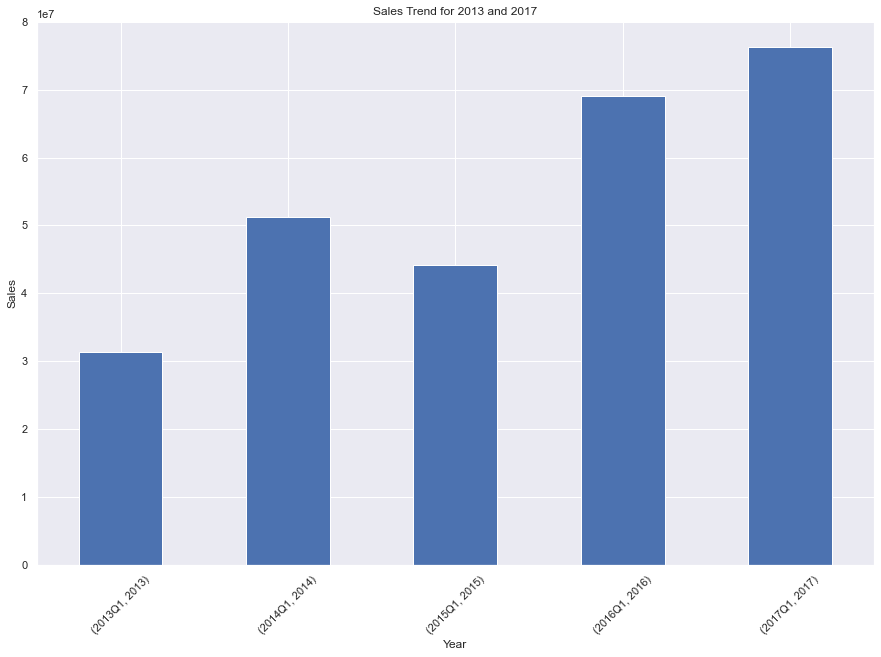

In [68]:
# create bar chart to represent the sales made in the 1st quater of each year
first_quarter_data.plot(kind='bar', stacked=False, figsize=(15,10))
plt.xticks(rotation=45)
plt.title('Sales Trend for 2013 and 2017')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

There has been a steady growth across the years. The sales keep growing Quarter on Quarter every year.

### 10. What is the trend of the sales over the years?

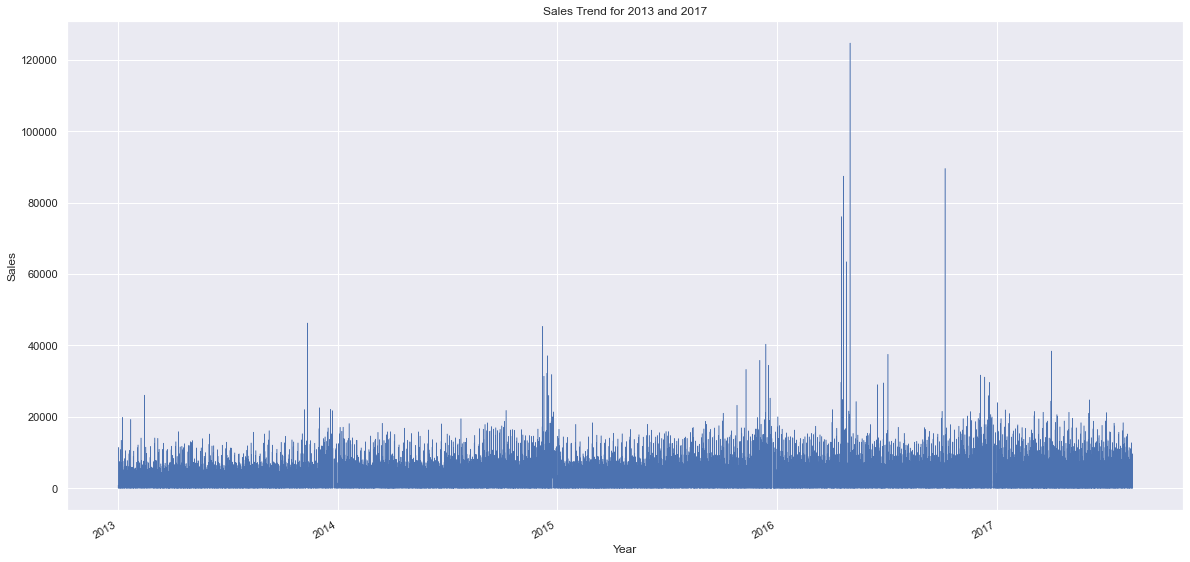

In [69]:
#Trend of sales over the years
df['sales'].plot(linewidth=0.5, figsize=(20,10))
plt.title('Sales Trend for 2013 and 2017')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

# Feature Processing & Engineering

## New Features Creation

In [70]:
#Creating the Day, Month and Year column from the Date Column
df['year'] = df.index.year
df['month'] =df.index.month
df['day']=df.index.day
df['dayofweek']=df.index.weekday
df['end_month']=df.index.is_month_end

In [71]:
# categorizing the products
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
df['family'] = np.where(df['family'].isin(food_families), 'FOODS', df['family'])
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
df['family'] = np.where(df['family'].isin(home_families), 'HOME', df['family'])
clothing_families = ['LINGERIE', 'LADYSWARE']
df['family'] = np.where(df['family'].isin(clothing_families), 'CLOTHING', df['family'])
grocery_families = ['GROCERY I', 'GROCERY II']
df['family'] = np.where(df['family'].isin(grocery_families), 'GROCERY', df['family'])
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
df['family'] = np.where(df['family'].isin(stationery_families), 'STATIONERY', df['family'])
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
df['family'] = np.where(df['family'].isin(cleaning_families), 'CLEANING', df['family'])
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']
df['family'] = np.where(df['family'].isin(hardware_families), 'HARDWARE', df['family'])

In [72]:
df.rename(columns = {"type_x":"store_type","family":"products"}, inplace = True)

In [73]:
df.head()

,id,store_nbr,products,sales,onpromotion,city,state,store_type,cluster,type_y,locale,locale_name,description,transferred,dcoilwtico,year,month,day,dayofweek,end_month
date,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.14,2013,1,1,1,False
2013-01-01,1.0,1,CLEANING,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.14,2013,1,1,1,False
2013-01-01,2.0,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.14,2013,1,1,1,False
2013-01-01,3.0,1,FOODS,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.14,2013,1,1,1,False
2013-01-01,4.0,1,STATIONERY,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.14,2013,1,1,1,False


In [74]:
df.drop(['id','locale','locale_name','description','transferred','city','type_y'],axis=1,inplace=True)

In [75]:
df.reset_index(inplace=True)

In [76]:
df.head(5)

,date,store_nbr,products,sales,onpromotion,state,store_type,cluster,dcoilwtico,year,month,day,dayofweek,end_month
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Pichincha,D,13,93.14,2013,1,1,1,False
1,2013-01-01,1,CLEANING,0.0,0.0,Pichincha,D,13,93.14,2013,1,1,1,False
2,2013-01-01,1,BEAUTY,0.0,0.0,Pichincha,D,13,93.14,2013,1,1,1,False
3,2013-01-01,1,FOODS,0.0,0.0,Pichincha,D,13,93.14,2013,1,1,1,False
4,2013-01-01,1,STATIONERY,0.0,0.0,Pichincha,D,13,93.14,2013,1,1,1,False


In [77]:
df.isnull().sum()

date              0
store_nbr         0
products          0
sales          7128
onpromotion    7128
state             0
store_type        0
cluster           0
dcoilwtico        0
year              0
month             0
day               0
dayofweek         0
end_month         0
dtype: int64

In [78]:
df['sales'].fillna(0,inplace=True)

## Data spliting

In [79]:
# Calculate the number of rows in the data
n_rows = df.shape[0]

# Calculate the split point
split_point = int(n_rows * 0.85)

# Select the first 85% of the rows as the training data
X_train = df.iloc[:split_point]
y_train = X_train['sales']
X_train = X_train.drop('sales', axis=1)

# Select the remaining 15% of the rows as the validation data
X_eval = df.iloc[split_point:]
y_eval = X_eval['sales']
X_eval = X_eval.drop('sales', axis=1)


In [80]:
X_train.shape,X_eval.shape,y_train.shape,y_eval.shape

((2602254, 13), (459222, 13), (2602254,), (459222,))

## Impute Missing Values

In [81]:
X_train.isnull().sum()

date           0
store_nbr      0
products       0
onpromotion    0
state          0
store_type     0
cluster        0
dcoilwtico     0
year           0
month          0
day            0
dayofweek      0
end_month      0
dtype: int64

In [82]:
categorical_columns = ['products', 'end_month', 'store_type', 'state']

In [83]:
numerical_columns =['store_nbr','onpromotion','cluster','dcoilwtico','year','month','day','dayofweek']

In [84]:
'''creating copy of the categorical features and numerical features
before imputing null value to avoid modifying the orginal dataset'''

X_train_cat = X_train[categorical_columns].copy()
X_train_num = X_train[numerical_columns].copy()

X_eval_cat = X_eval[categorical_columns].copy()
X_eval_num = X_eval[numerical_columns].copy()

In [85]:
# Creating imputer variables
numerical_imputer = SimpleImputer(strategy = "mean")
categorical_imputer = SimpleImputer(strategy = "most_frequent")

In [86]:
# Fitting the Imputer
X_train_cat_imputed = categorical_imputer.fit_transform(X_train_cat)
X_train_num_imputed = numerical_imputer.fit_transform(X_train_num)

X_eval_cat_imputed = categorical_imputer.fit_transform(X_eval_cat)
X_eval_num_imputed = numerical_imputer.fit_transform(X_eval_num)

## Features Encoding

In [87]:
encoder=OneHotEncoder(handle_unknown='ignore')

In [88]:
# encoding the xtrain categories and converting to a dataframe
X_train_cat_encoded = encoder.fit(X_train_cat_imputed)
X_train_cat_encoded = pd.DataFrame(encoder.transform(X_train_cat_imputed).toarray(),
                                   columns=encoder.get_feature_names(categorical_columns))

In [89]:
# encoding the xeval categories and converting to a dataframe
X_eval_cat_encoded = encoder.fit(X_eval_cat_imputed)
X_eval_cat_encoded = pd.DataFrame(encoder.transform(X_eval_cat_imputed).toarray(),
                                   columns=encoder.get_feature_names(categorical_columns))

## Data scalling

In [90]:
scaler= StandardScaler()

In [91]:
X_train_num_scaled = scaler.fit_transform(X_train_num_imputed)
X_train_num_sc = pd.DataFrame(X_train_num_scaled, columns = numerical_columns)

In [92]:
X_eval_num_scaled = scaler.fit_transform(X_eval_num_imputed)
X_eval_num_sc = pd.DataFrame(X_eval_num_scaled, columns = numerical_columns)

## Combining the xtrain cat and xtrain num

In [93]:
X_train_df = pd.concat([X_train_num_sc,X_train_cat_encoded], axis =1)
X_eval_df = pd.concat([X_eval_num_sc,X_eval_cat_encoded], axis =1)

In [94]:
X_train_df.head()

,store_nbr,onpromotion,cluster,dcoilwtico,year,month,day,dayofweek,products_AUTOMOTIVE,products_BEAUTY,...,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua
0,-1.700128,-0.173535,0.971672,1.161929,-1.332498,-1.604796,-1.662658,-1.004298,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.700128,-0.173535,0.971672,1.161929,-1.332498,-1.604796,-1.662658,-1.004298,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.700128,-0.173535,0.971672,1.161929,-1.332498,-1.604796,-1.662658,-1.004298,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.700128,-0.173535,0.971672,1.161929,-1.332498,-1.604796,-1.662658,-1.004298,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.700128,-0.173535,0.971672,1.161929,-1.332498,-1.604796,-1.662658,-1.004298,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [95]:
X_eval_df.head()

,store_nbr,onpromotion,cluster,dcoilwtico,year,month,day,dayofweek,products_AUTOMOTIVE,products_BEAUTY,...,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua
0,-0.225495,-0.331062,-1.608553,0.548863,-2.011529,2.212358,-0.776607,0.489502,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.225495,1.247247,-1.608553,0.548863,-2.011529,2.212358,-0.776607,0.489502,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.225495,0.757427,-1.608553,0.548863,-2.011529,2.212358,-0.776607,0.489502,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.225495,3.097679,-1.608553,0.548863,-2.011529,2.212358,-0.776607,0.489502,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.225495,1.192823,-1.608553,0.548863,-2.011529,2.212358,-0.776607,0.489502,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Machine learning models

### Decision Tree Regression Model

In [96]:
#fitting decision tree model
dt_model=DecisionTreeRegressor()
dt_model.fit(X_train_df,y_train)

DecisionTreeRegressor()

In [97]:
#to measure the this regression model's rmse
dt_pred=dt_model.predict(X_eval_df)
dt_mse=mean_squared_error(y_eval,dt_pred)
dt_rmse= np.sqrt(dt_mse)
dt_MAE=mean_absolute_error(y_eval,dt_pred)
dt_rmsle = np.sqrt(mean_squared_log_error(y_eval,dt_pred))

In [98]:
results=pd.DataFrame([['Decision Tree', dt_mse,dt_rmse,dt_MAE,dt_rmsle]],
                     columns = ['Model', 'MSE','RMSE','MAE','RMSLE'])
results

,Model,MSE,RMSE,MAE,RMSLE
0,Decision Tree,1.100311e+06,1048.957255,379.52897,1.914334


## Cleaning Test Data

In [99]:
test_events_df=pd.merge(test_df,events_df,on='date',how='left')
test_events_df.head()

,id,date,store_nbr,family,onpromotion,type,locale,locale_name,description,transferred
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,NaN,NaN,NaN,NaN
1,3000889,2017-08-16,1,BABY CARE,0,NaN,NaN,NaN,NaN,NaN
2,3000890,2017-08-16,1,BEAUTY,2,NaN,NaN,NaN,NaN,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,NaN,NaN,NaN,NaN,NaN
4,3000892,2017-08-16,1,BOOKS,0,NaN,NaN,NaN,NaN,NaN


In [100]:
oil_test_events=pd.merge(test_events_df,oil_data,on ='date',how= 'left')
oil_test_events.head()

,id,date,store_nbr,family,onpromotion,type,locale,locale_name,description,transferred,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,NaN,NaN,NaN,NaN,46.8
1,3000889,2017-08-16,1,BABY CARE,0,NaN,NaN,NaN,NaN,NaN,46.8
2,3000890,2017-08-16,1,BEAUTY,2,NaN,NaN,NaN,NaN,NaN,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,NaN,NaN,NaN,NaN,NaN,46.8
4,3000892,2017-08-16,1,BOOKS,0,NaN,NaN,NaN,NaN,NaN,46.8


In [101]:
merged_test=pd.merge(oil_test_events,store_df,on ='store_nbr',how= 'left')
merged_test.head()

,id,date,store_nbr,family,onpromotion,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13


In [102]:
merged_test=merged_test.drop(['id','locale','locale_name','description','transferred','city','type_x'],axis=1)

In [103]:
merged_test.rename(columns={'type_y':'store_type','family':'products'},inplace =True)

In [104]:
merged_test=merged_test.set_index(['date'])

In [105]:
merged_test['year'] = merged_test.index.year
merged_test['month'] =merged_test.index.month
merged_test['day']=merged_test.index.day
merged_test['dayofweek']=merged_test.index.weekday
merged_test['end_month']=merged_test.index.is_month_end

In [106]:
# categorizing the products
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
merged_test['products'] = np.where(merged_test['products'].isin(food_families), 'FOODS', merged_test['products'])
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
merged_test['products'] = np.where(merged_test['products'].isin(home_families), 'HOME', merged_test['products'])
clothing_families = ['LINGERIE', 'LADYSWARE']
merged_test['products'] = np.where(merged_test['products'].isin(clothing_families), 'CLOTHING', merged_test['products'])
grocery_families = ['GROCERY I', 'GROCERY II']
merged_test['products'] = np.where(merged_test['products'].isin(grocery_families), 'GROCERY', merged_test['products'])
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
merged_test['products'] = np.where(merged_test['products'].isin(stationery_families), 'STATIONERY', merged_test['products'])
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
merged_test['products'] = np.where(merged_test['products'].isin(cleaning_families), 'CLEANING', merged_test['products'])
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']
merged_test['products'] = np.where(merged_test['products'].isin(hardware_families), 'HARDWARE', merged_test['products'])

In [107]:
merged_test.reset_index(inplace=True)

In [108]:
merged_test.shape

(28512, 13)

In [109]:
merged_test.head()

,date,store_nbr,products,onpromotion,dcoilwtico,state,store_type,cluster,year,month,day,dayofweek,end_month
0,2017-08-16,1,AUTOMOTIVE,0,46.8,Pichincha,D,13,2017,8,16,2,False
1,2017-08-16,1,CLEANING,0,46.8,Pichincha,D,13,2017,8,16,2,False
2,2017-08-16,1,BEAUTY,2,46.8,Pichincha,D,13,2017,8,16,2,False
3,2017-08-16,1,FOODS,20,46.8,Pichincha,D,13,2017,8,16,2,False
4,2017-08-16,1,STATIONERY,0,46.8,Pichincha,D,13,2017,8,16,2,False


## Imputing missing values

In [110]:
X_test_cat = merged_test[categorical_columns].copy()
X_test_num = merged_test[numerical_columns].copy()

In [111]:
# fitting imputer
X_test_cat_imputed = categorical_imputer.fit_transform(X_test_cat)
X_test_num_imputed = numerical_imputer.fit_transform(X_test_num)

### Feature Encoding

In [112]:
# encoding the xtrain categories and converting to a dataframe
X_test_cat_encoded = encoder.fit(X_test_cat_imputed)
X_test_cat_encoded = pd.DataFrame(encoder.transform(X_test_cat_imputed).toarray(),
                                   columns=encoder.get_feature_names(categorical_columns))

## Data scalling

In [113]:
X_test_num_scaled = scaler.fit_transform(X_test_num_imputed)
X_test_num_sc = pd.DataFrame(X_test_num_scaled, columns = numerical_columns)

## Combining xtest cat and xtest num

In [114]:
X_test_df = pd.concat([X_test_num_sc,X_test_cat_encoded], axis =1)

In [115]:
X_test_df.head()

,store_nbr,onpromotion,cluster,dcoilwtico,year,month,day,dayofweek,products_AUTOMOTIVE,products_BEAUTY,...,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua
0,-1.700267,-0.336759,0.97178,-0.685361,0.0,0.0,-1.626978,-0.496972,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.700267,-0.336759,0.97178,-0.685361,0.0,0.0,-1.626978,-0.496972,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.700267,-0.240064,0.97178,-0.685361,0.0,0.0,-1.626978,-0.496972,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.700267,0.630191,0.97178,-0.685361,0.0,0.0,-1.626978,-0.496972,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.700267,-0.336759,0.97178,-0.685361,0.0,0.0,-1.626978,-0.496972,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Making predictions with unseen data

In [116]:
dtree_predictions=dt_model.predict(X_test_df)

In [117]:
X_test_df['sales'] = dtree_predictions

In [118]:
X_test_df['sales'].to_csv('submission.csv', index=False)

## Exporting Key Componets

In [119]:
if not os.path.exists("export"):
    os.makedirs("export")

In [120]:
# set the destination path to the "export" directory
destination = os.path.join(".", "export")   

In [121]:
components = {
    "num_imputer":numerical_imputer,
    "cat_imputer": categorical_imputer,
    "encoder": encoder,
    "scaler": scaler,
    "models": dt_model 
}

In [122]:
# Export the KNN model
with open(os.path.join(destination, "dt_model.pkl"), "wb") as f:
    pickle.dump(components, f)

In [123]:
!pip freeze > export/requirements.txt